# 1. Elija una de las imágenes color que tomó para la clase y aplique separación de canales y elija un método para transformarla en escala de grises. Muestre por pantalla los resultados obtenidos.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2

## Imagen original

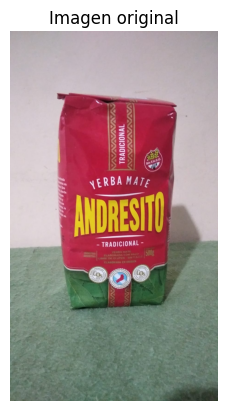

(<matplotlib.image.AxesImage at 0x7fd4acbd8ee0>,
 Text(0.5, 1.0, 'Imagen original'),
 None)

In [2]:
img1 = cv2.imread('img/img2.jpeg')
plt.axis('off')

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_rgb), plt.title('Imagen original'), plt.show()

## Separación de canales RGB

In [3]:
img1_R, img1_G, img1_B = cv2.split(img1_rgb)

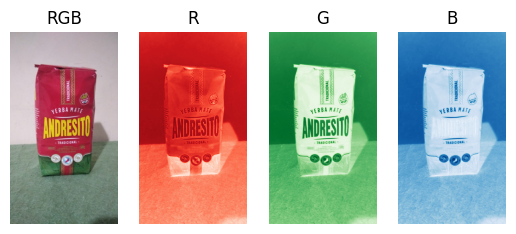

In [4]:
plt.subplot(141)
plt.axis('off')
plt.title('RGB')
plt.imshow(img1_rgb)

plt.subplot(142)
plt.axis('off')
plt.title('R')
plt.imshow(img1_R, cmap='Reds')

plt.subplot(143)
plt.axis('off')
plt.title('G')
plt.imshow(img1_G, cmap='Greens')

plt.subplot(144)
plt.axis('off')
plt.title('B')
plt.imshow(img1_B, cmap='Blues')

plt.show()

## Escala de grises

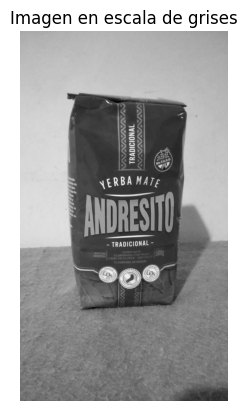

In [5]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
plt.imshow(img1_gray, cmap='gray')
plt.axis('off')
plt.title('Imagen en escala de grises')
plt.show()

# 2. Con las fotografías pedidas por la cátedra la clase pasada (la foto de objetos con fondo liso, y fotos del mismo producto en un contexto más complejo) usar los métodos de extracción de características (esos anteriores al Deep Learning) para encontrar la ubicación del producto dentro de la imagen.

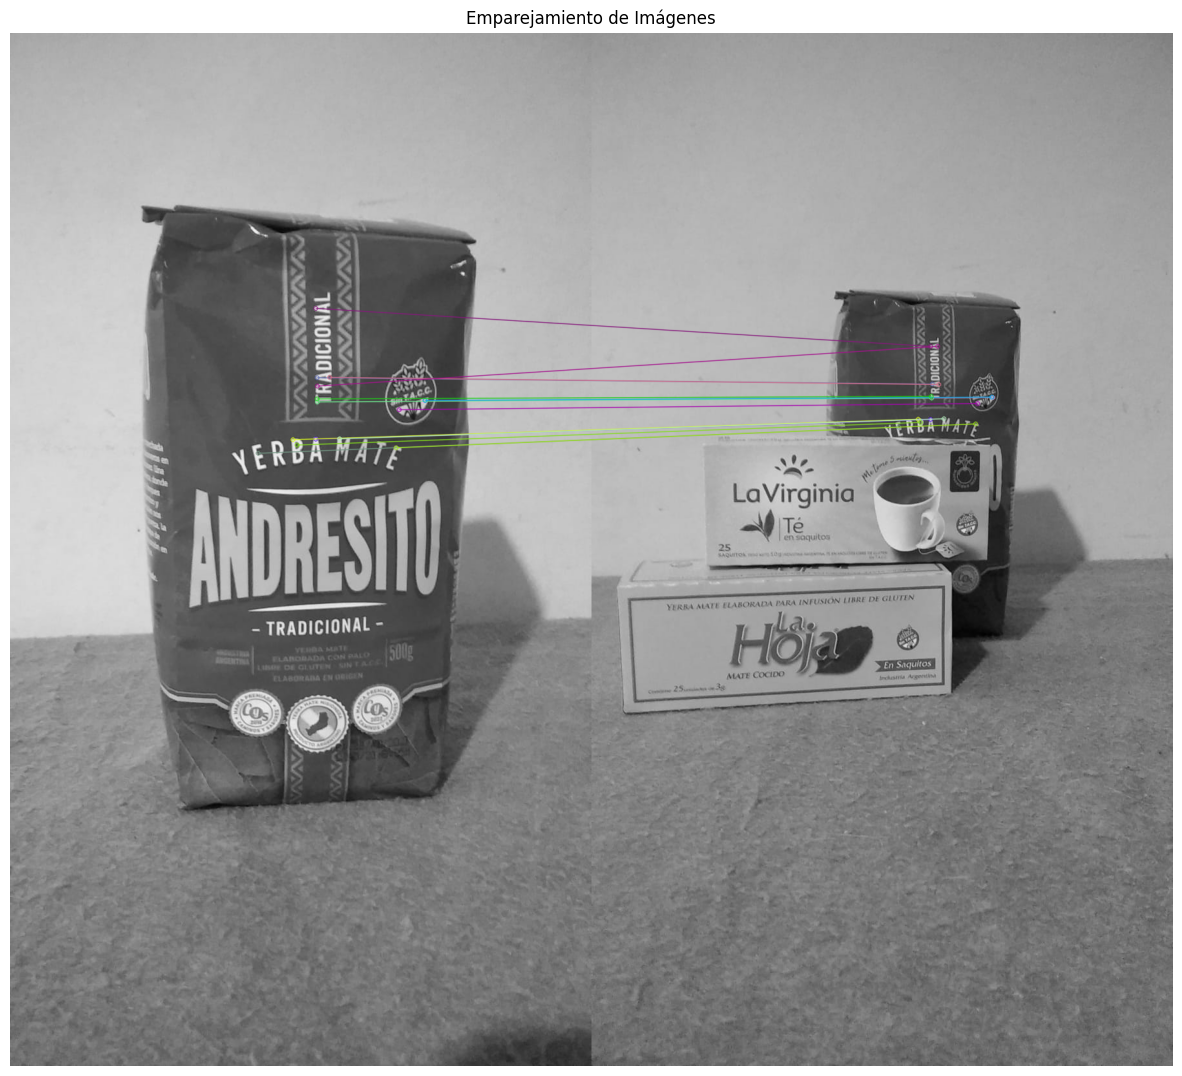

In [6]:
img_sin_oclusion = cv2.imread('img/img2.jpeg', cv2.IMREAD_GRAYSCALE)
img_con_oclusion = cv2.imread('img/img5.jpeg', cv2.IMREAD_GRAYSCALE)

# Inicializar ORB
orb = cv2.ORB_create()

# Detectar keypoints y calcular descriptores
keypoints1, descriptors1 = orb.detectAndCompute(img_sin_oclusion, None)
keypoints2, descriptors2 = orb.detectAndCompute(img_con_oclusion, None)

# Crear un objeto BFMatcher para encontrar las coincidencias
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Encontrar coincidencias
matches = bf.match(descriptors1, descriptors2)

# Ordenar las coincidencias en orden de distancia (cuanto más baja, mejor)
matches = sorted(matches, key=lambda x:x.distance)

# Dibujar las primeras 15 coincidencias
matched_img = cv2.drawMatches(img_sin_oclusion,
                              keypoints1, 
                              img_con_oclusion,
                              keypoints2,
                              matches[:15],
                              outImg=None,
                              flags=2)

# Ajustar el tamaño de la figura de matplotlib
plt.figure(figsize=(15, 20))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title('Emparejamiento de Imágenes')
plt.axis('off')
plt.show()

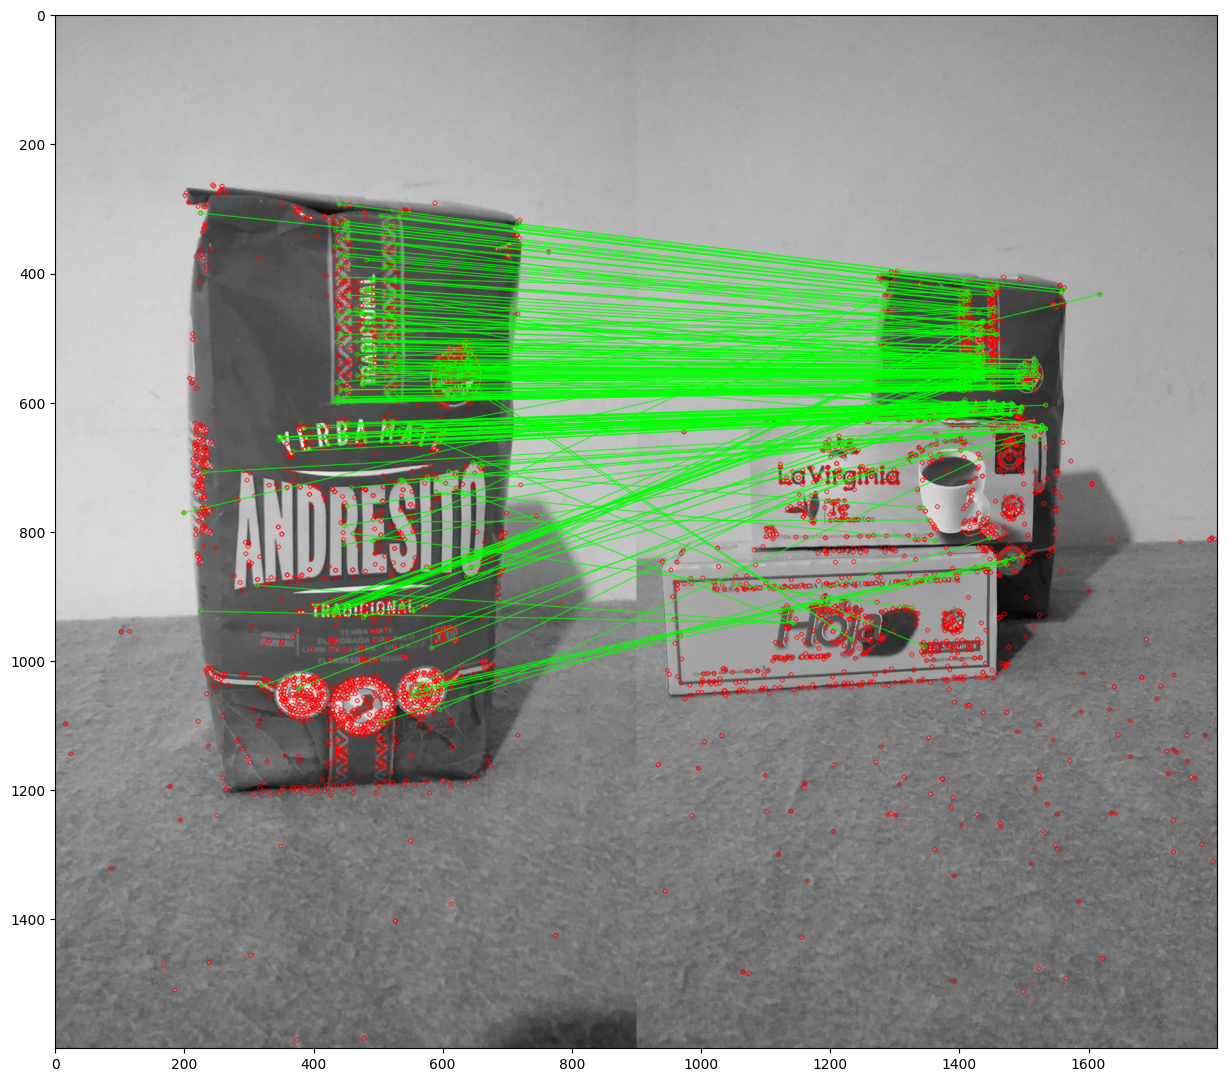

(<matplotlib.image.AxesImage at 0x7fd456f76a10>, None)

In [7]:
# Iniciar el detector SIFT
sift = cv2.SIFT_create()

# Encontrar los keypoints y descriptores con SIFT
kp1, des1 = sift.detectAndCompute(img_sin_oclusion, None)
kp2, des2 = sift.detectAndCompute(img_con_oclusion, None)

# Parámetros FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # o pasar un diccionario vacío

# Iniciar FLANN matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Realizar emparejamientos kNN
matches = flann.knnMatch(des1, des2, k=2)

# Necesitamos dibujar solo los buenos emparejamientos, por lo que creamos una máscara
matchesMask = [[0, 0] for i in range(len(matches))]

# Test de proporción según el artículo de Lowe (https://www.robots.ox.ac.uk/~vgg/research/affine/det_eval_files/lowe_ijcv2004.pdf)
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

# Parámetros de dibujo para los emparejamientos
draw_params = dict(matchColor=(0, 255, 0),  # color de los emparejamientos
                   singlePointColor=(255, 0, 0),  # color de los puntos individuales
                   matchesMask=matchesMask,  # máscara para seleccionar emparejamientos
                   flags=cv2.DrawMatchesFlags_DEFAULT)

# Dibujar los emparejamientos kNN
img3 = cv2.drawMatchesKnn(img_sin_oclusion,
                          kp1,
                          img_con_oclusion,
                          kp2,
                          matches,
                          None,
                          **draw_params)

plt.figure(figsize=(15, 20))
# Mostrar la imagen resultante
plt.imshow(img3), plt.show()

# 4. Con los videos de `youtube.com` de cámara fija pedidos para esta clase, aplicar los algoritmos de detección de movimiento vistos en la teoría.

In [19]:
from pytube import YouTube
import os

# URL del video
url = 'https://www.youtube.com/watch?v=XXdPNnS_XAA'

output_file = 'img/highway.mp4'

if not os.path.isfile(output_file):
    yt = YouTube(url)

    # Seleccionar el stream con resolución 720p
    video = yt.streams.filter(progressive=True,
                              file_extension='mp4',
                              res='720p').first()
    # Guardamos el video
    video.download(filename=output_file)